In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.manifold import TSNE

from warnings import simplefilter
simplefilter('ignore', category=UserWarning) # ignore a pesky warning in fashion plot

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

## Lab 6: Principal Components Analysis (PCA)

**Harvard University**<br/>
**Fall 2023**<br/>
**Instructors**: Pavlos Protopapas and Kevin Rader<br/>
<hr style='height:2px'>

## Topics
- Finding Principle Components
    1. eigenvector decomposition
    2. singular value decomposition (SVD)
    3. SKLearn's PCA class
- Projecting the Data onto the Principle Components
- Inspecting Predictors' Contributions to Each Component
- Principle Component Regression (PCR)
    - Coefficients in terms of the original predictors
    - Selecting the number of components
    - PCA /w cross-validation & regularization
- More PCA visualization examples
- t-SNE: Non-linear dimensionality reduction

## Test Scores Data

For our first example, we'll use a data set of test scores in different courses for 1,000 students.

The dataset is in `data/exams.csv`

Read in the csv into a DataFrame and take a look with `df.head()`.

In [2]:
df = pd.read_csv('data/exams.csv')
df.head()

,Hindi,English,Science,Maths,History,Geography,Total,Results,Div
0,65,10,59,3,71,37,245,0,3
1,94,56,4,67,91,50,362,1,1
2,7,85,76,99,60,25,352,0,2
3,88,46,59,94,52,38,377,1,1
4,39,81,37,38,6,54,255,1,3


Define `X` to be only the course score columns, ignoring `Total`, `Results`, and `Div`.

In [3]:
X = df[['Hindi', 'English', 'Science', 'Maths', 'History', 'Geography']]
X

,Hindi,English,Science,Maths,History,Geography
0,65,10,59,3,71,37
1,94,56,4,67,91,50
2,7,85,76,99,60,25
3,88,46,59,94,52,38
4,39,81,37,38,6,54
...,...,...,...,...,...,...
995,55,89,68,58,13,13
996,42,62,25,87,51,68
997,9,83,70,14,11,78
998,23,82,31,42,84,52


## 3 Ways to find the Principle Components

### (1) Eigenvectors of the predictor covariance matrix

The eigenvectors of the predictor covariance matrix, ordered by decreasing eigenvalues, correspond to orthogonal vectors in the predictor space ordered by decreasing amount of explained variance. Refer to the PCA advanced section for more details.

Quick recap on **eigenvectors**. The eigenvectors of a matrix $\bf{A}$ are the vectors that, when multiplied by $\bf{A}$ produce scalar multiples of themselves.
$$\bf{A}v = \lambda v$$
$\lambda$, the scaling factor, is known as the **eigenvalue**. We add the additional constrained that eigenvectors have unit length.

![img](img/eigenvectors.gif)

**Q:** Is the yellow vector an eigenvector?

**Note:** PCA requires that the data matrix be **centered** (i.e., mean = 0). This is a natural step in calculating the covariance matrix. But we will go one step further in our examples and **standardize** our data (mean = 0 *and* stdev = 1). This helps prevent the directions of maximum variance from being influenced by the scale of our predictors. 

Let's standardize manually $$\frac{X-\mu_X}{\sigma_X}$$

In [4]:
X_std = ((X-X.mean(axis=0))/X.std())

In [5]:
X_std.describe()

,Hindi,English,Science,Maths,History,Geography
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,-1.030287e-16,1.953993e-17,5.329071e-17,8.526513e-17,3.907985e-17,3.996803e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.752346e+00,-1.786548e+00,-1.709478e+00,-1.730659e+00,-1.704360e+00,-1.742512e+00
25%,-8.701505e-01,-8.595824e-01,-8.450574e-01,-8.313296e-01,-8.701501e-01,-8.369131e-01
50%,4.597598e-02,1.390448e-02,1.936302e-02,-1.931375e-02,-1.181797e-03,-3.580600e-02
75%,8.603107e-01,8.873913e-01,8.232740e-01,8.538215e-01,8.417174e-01,8.697933e-01
max,1.606784e+00,1.743052e+00,1.713627e+00,1.726957e+00,1.736755e+00,1.705731e+00


Next, we calculate the covaraince between predictors. There are several ways to do this with numpy.\
**Note:** Again, if our standardized data matrix $\bf{\tilde{X}}$ is $n\times p$ ($n$ observations and $p$ predictors) then we want the $p \times p$ correlation matrix which would be $\frac{1}{n-1}\bf{\tilde{X}^\top} \bf{\tilde{X}}$

In [6]:
N = X_std.shape[0]

X_cov = np.dot(X_std.T, X_std) / (N-1)

X_cov2 = (X_std.T@X_std)/(N-1)

X_cov3 = np.cov(X_std.T)

In [7]:
assert np.allclose(X_cov, X_cov2)
assert np.allclose(X_cov2, X_cov3)

In [8]:
X_cov

array([[ 1.        ,  0.03645489,  0.03761585,  0.04123955, -0.02465249,
        -0.06418909],
       [ 0.03645489,  1.        , -0.02241089, -0.01126872, -0.00181201,
         0.05225262],
       [ 0.03761585, -0.02241089,  1.        ,  0.05631362,  0.00560505,
         0.02884582],
       [ 0.04123955, -0.01126872,  0.05631362,  1.        ,  0.01152499,
        -0.00114035],
       [-0.02465249, -0.00181201,  0.00560505,  0.01152499,  1.        ,
        -0.022318  ],
       [-0.06418909,  0.05225262,  0.02884582, -0.00114035, -0.022318  ,
         1.        ]])

We can then use `np.linalg.eig` to find the eigenvalues and eigenvectors of the covariance matrix.

In [9]:
eig_vals, eig_vecs = np.linalg.eig(X_cov)

It is the **columns** of the 2nd object returned which are the eigenvectors.

The numpy `eig` method doesn't guarantee these to be sorted by eigenvalue!\
We need to insure that ourselves.

In [10]:
# get order of eigen values (decreasing)
idx = np.argsort(eig_vals)[::-1]
# resort eigenvals on this order
eig_vals = eig_vals[idx]
# resort the eigenvectors (columns)
eig_vecs = eig_vecs[:,idx]

In [11]:
eig_vecs.shape

(6, 6)

Here's the eigenvector with the largest eigenvalue (1st column).

In [12]:
eig_vecs[:,0]

array([-0.58274167,  0.13292184, -0.48189758, -0.55084657, -0.02283826,
        0.32644313])

**Q:** Are we able to put any interpretation on this eigenvector?

### (2) PCA with SVD

You could also use singular value decomposition (SVD) of the data matrix to get the eigenvectors.\
$\bf{\tilde{X}}$ denotes the standardized data matrix.
$$\bf{\tilde{X}} = \bf{U\Sigma V^\top}$$
*Columns* of $\bf{U}$ are eigenvectors of the *row* (observation) covaraince matrix.\
*Rows* of $\bf{V^\top}$ are eigenvectors of the *column* (predictor) covariance matrix.\
It is the later that we are interested in here. You can always check the shapes if you aren't sure.

Unlike, `eig`, the results of `svd` *are* sorted by the singular values (which is equivalent to sorting by the eigenvectors).

In [13]:
U, Sigma, V_T = np.linalg.svd(X_std)
U.shape, Sigma.shape, V_T.shape

((1000, 1000), (6,), (6, 6))

Here's the eigenvector with the largest eigenvalue (1st row of $\bf{V^\top}$)

In [14]:
V_T[0]

array([-0.58274167,  0.13292184, -0.48189758, -0.55084657, -0.02283826,
        0.32644313])

### (3) PCA with SKLearn

SKLearn provides the `PCA` class for not only calculating the principle components (`fit`) but also projecting data into the space spanned by the components (`transform`).\
You can also do both at once with `fit_transform`.

In [15]:
X_std = StandardScaler().fit_transform(X)

In [16]:
pca = PCA().fit(X_std)

In [17]:
X_pca = pca.transform(X_std)

In [18]:
X_pca.shape

(1000, 6)

You can access the number of components with the `n_components_` attribute.

In [19]:
pca.n_components_

6

There are the `explained_variance_` and `explained_variance_ratio_` attributes as well which describe how much of the variance is explained by each component.

In [20]:
pca.explained_variance_

array([1.09786298, 1.05742308, 1.03775782, 1.00013994, 0.94289184,
       0.86993034])

In [21]:
pca.explained_variance_ratio_

array([0.18279419, 0.17606094, 0.17278668, 0.1665233 , 0.15699149,
       0.1448434 ])

Finally, there the components themselves, which are the *rows* of the `components_` attribute.

In [22]:
pca.components_[0]

array([-0.58274167,  0.13292184, -0.48189758, -0.55084657, -0.02283826,
        0.32644313])

All 3 approachs above will give us the same results for principle components!

In [23]:
# sklearn compared to SVD
assert np.allclose(pca.components_[0], V_T[0])
# sklearn compared to eigenvector decomposition
assert np.allclose(pca.components_[0], eig_vecs[:,0])

## Predictors' Contributions to Components

If we want to see how much predictor $x_i$ contributs to each we can look at the columns of `pca.components_` (remember, the rows of this are the components themselves!) 

For a few of the predictors, print the predictor name and its contributions to each of the principle components.

In [24]:
i = 2
print(X.columns[i], pca.components_[:,i])

Science [-0.48189758  0.37975243  0.36988849 -0.11714758 -0.60097507  0.33444092]


In [25]:
list(zip(X.columns, pca.components_[0]))

[('Hindi', -0.5827416724657838),
 ('English', 0.13292183995122364),
 ('Science', -0.481897579827803),
 ('Maths', -0.5508465736403784),
 ('History', -0.022838260720313974),
 ('Geography', 0.32644312881081516)]

In [26]:
list(zip(X.columns, pca.components_[1]))

[('Hindi', -0.0004054306723262444),
 ('English', 0.48283852951650946),
 ('Science', 0.3797524301920181),
 ('Maths', 0.22317247898749049),
 ('History', -0.21883276920226816),
 ('Geography', 0.724542024695191)]

Now let's **create a plot** that shows:
1. A 2D PCA projection of the X data
2. Annotated arrows showing the contribution of each predictor to the 2 plotted components
3. Colored observations based on the value of their `Results` predictor

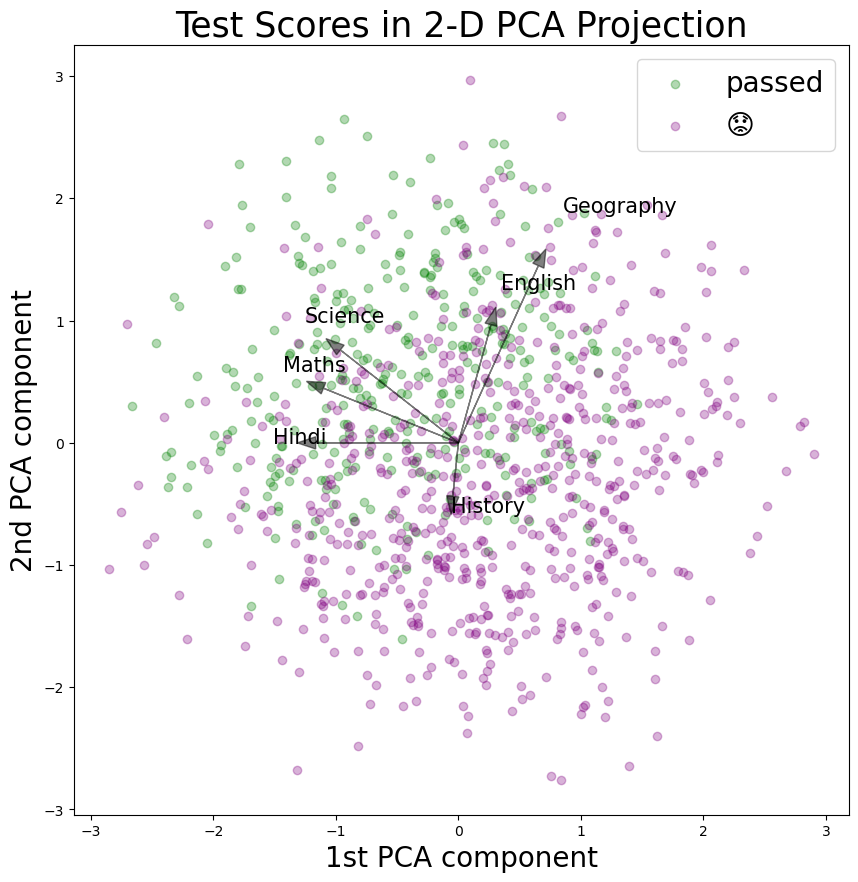

In [27]:
plt.figure(figsize=(10,10))
passed = df.Results == 1

plt.scatter(X_pca[passed,0], X_pca[passed,1], c='green', alpha=0.3, label="passed")
plt.scatter(X_pca[~passed,0], X_pca[~passed,1], c='purple', alpha=0.3, label="😟")
# scale up contributions by 2x for improved visibility
for i, vec in enumerate(pca.components_.T*2):
    plt.arrow(0, 0, vec[0], vec[1], color='k', head_width=0.1, alpha=0.5)
    offset = 1.3
    plt.annotate(X.columns[i],
                 (offset*vec[0], offset*vec[1]), color='k', fontsize=15)
plt.legend(fontsize=20)
plt.xlabel('1st PCA component', fontsize=20)
plt.ylabel('2nd PCA component', fontsize=20);
plt.title("Test Scores in 2-D PCA Projection", fontsize=25);

Can you say anything about the relationship between certain tests scores and students' results?

Finally, we'll plot the explained variance ratio for each component as a bar plot.

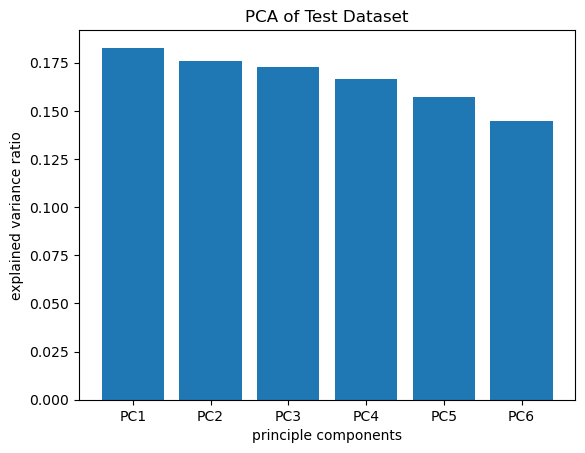

In [28]:
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.xticks(ticks=range(0, pca.n_components_), labels=[f'PC{i}' for i in range(1, pca.n_components_+1)]);
plt.ylabel('explained variance ratio')
plt.xlabel('principle components')
plt.title('PCA of Test Dataset');

Do the first few components dominate the explained variance?

## Wine Data (Visualization & PCR)

We'll use the popular wine dataset to look at another example of PCA for visualization as well as a first example of principle component regression (PCR).

In [29]:
wine_df = pd.read_csv('data/winequality.csv')
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red
0,6.7,0.20,0.42,14.0,0.038,83.0,160.0,0.99870,3.16,0.50,9.4,6,0
1,6.6,0.40,0.32,1.7,0.035,39.0,84.0,0.99096,3.59,0.48,12.7,7,0
2,6.4,0.26,0.35,7.7,0.056,45.0,191.0,0.99527,3.16,0.50,9.5,5,0
3,6.8,0.69,0.00,5.6,0.124,21.0,58.0,0.99970,3.46,0.72,10.2,5,1
4,5.9,0.25,0.19,12.4,0.047,50.0,162.0,0.99730,3.35,0.38,9.5,5,0


Peek at the columns and the shape.

In [30]:
wine_df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'red'],
      dtype='object')

In [31]:
wine_df.shape

(6497, 13)

## Projecting the Wine Data onto the 1st 2 Principle Components

The projection into the principle component space when fitting our PCR model happened "under the hood." Let's perform the projection explicitly ourself.

**First using SVD**

In [32]:
wine_std = StandardScaler().fit_transform(wine_df)
U, Sigma, V_T = np.linalg.svd(wine_std)

In [33]:
W = V_T.T

In [34]:
W[:,0]

array([ 0.26022761,  0.36378537, -0.11319392, -0.23277398,  0.30248902,
       -0.33871316, -0.40228457,  0.16134445,  0.17486612,  0.27953014,
       -0.00438771, -0.09658937,  0.46988304])

In [35]:
Z = wine_std@W

Create a scatter plot of the wine data projected onto the first 2 principle components.

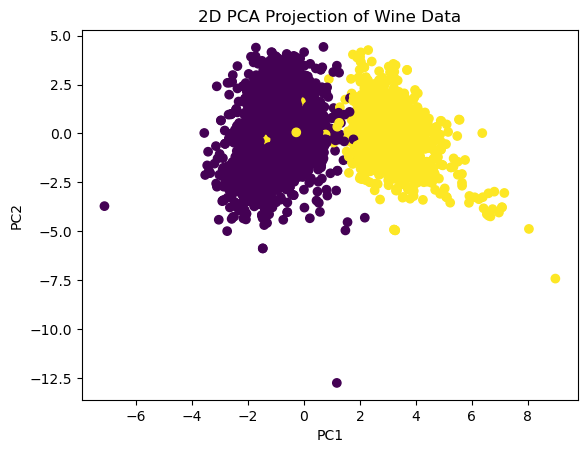

In [36]:
plt.scatter(Z[:,0], Z[:,1], c = wine_df.red)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Wine Data");

**Now with SKlearn** (both projecting and plotting)

In [37]:
pca = PCA(2).fit(wine_std)
wine_pca = pca.transform(wine_std)

In [38]:
pca.components_[0]

array([ 0.26022761,  0.36378537, -0.11319392, -0.23277398,  0.30248902,
       -0.33871316, -0.40228457,  0.16134445,  0.17486612,  0.27953014,
       -0.00438771, -0.09658937,  0.46988304])

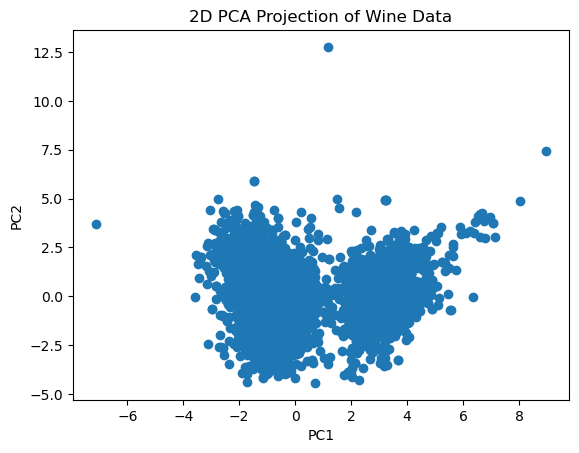

In [39]:
plt.scatter(wine_pca[:,0], wine_pca[:,1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Wine Data");

Are the results the same? If not, can you explain the difference?

Do you see any clustering in the projection? Do you have a possible explanation? How might you test it?

## Principal Component Regression (PCR)

We haven't covered classification yet in the course so we'll choose a continuous response variable like `alcohol`.

In [40]:
response = 'alcohol'
X = wine_df.drop(response, axis=1)
y = wine_df[response]

Train / Test split\
Use 20% for test, stratify on the 'red' column, and use 109 for the random state.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=X['red'], random_state=109)

Scale the data

In [42]:
scaler = StandardScaler()
X_std_train = scaler.fit_transform(X_train)
X_std_test = scaler.transform(X_test)

Fit and score a linear regression model.

In [43]:
lm = LinearRegression().fit(X_std_train, y_train)

In [44]:
lm.score(X_std_train, y_train), lm.score(X_std_test, y_test)

(0.8193744658271392, 0.8510170596982802)

Let's see if we can get some improvement by adding up to degree 3 polynomial features and interation terms.

In [45]:
poly = PolynomialFeatures(degree=3, include_bias=False).fit(X_std_train)

In [46]:
X_poly_train = poly.transform(X_std_train)
X_poly_test = poly.transform(X_std_test)

In [47]:
X_poly_train.shape

(5197, 454)

In [48]:
lm_poly = LinearRegression().fit(X_poly_train, y_train)
lm_poly.score(X_poly_train, y_train), lm_poly.score(X_poly_test, y_test)

(0.9201946248107519, 0.8654133066752918)

We'll now try **PCR**, where we fit a regression model using the principle components as the predictors.

The first step will be to **fit the PCA object**.

In [49]:
pca = PCA().fit(X_poly_train)

Now we need to decide: **how many components should we use in our regression model?**

Let's try to **'eyeball' it by creating a plot** visualizing the amount of variance explained by each new component and look for a point of diminishing returns (i.e., an "elbow" or "knee" in the plot).

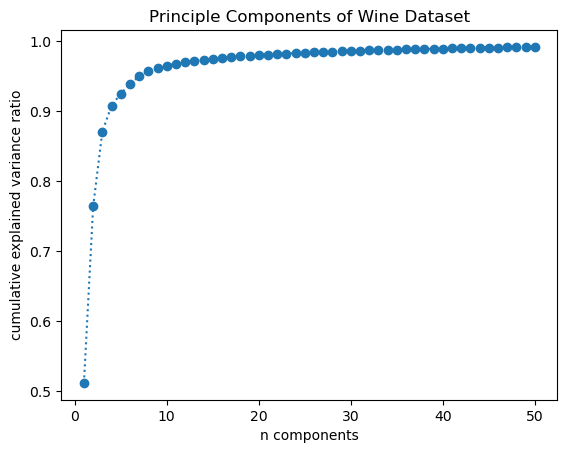

In [50]:
n_to_plot = 50
plt.plot(range(1, n_to_plot+1), np.cumsum(pca.explained_variance_ratio_[:n_to_plot]), 'o:')
plt.xlabel('n components')
plt.ylabel('cumulative explained variance ratio') 
plt.title('Principle Components of Wine Dataset');

Pick an eyeballed value for n based on your plot.

In [51]:
eyeballed_n = 7

PCA **transform** (i.e., project) the train and test design matrices, **fit** your model, and **score** on train and test.

You can either create a new PCA object specifying `n_components`, or you can just index into the full component matrix when fitting and scoreing.

How did you do?

In [52]:
X_pca_train = pca.transform(X_poly_train)
X_pca_test = pca.transform(X_poly_test)

In [53]:
pcr = LinearRegression().fit(X_pca_train[:,:eyeballed_n], y_train)

In [54]:
pcr.score(X_pca_train[:, :eyeballed_n], y_train), pcr.score(X_pca_test[:, :eyeballed_n], y_test)

(0.004566132282102675, 0.002806296433593425)

In [55]:
print(u"\U0001F4A9")

💩


Can you think of a possible explanation for these results?

## PCR Coefficients in terms of the Original Predictors

<img src='img/pcr_coefs.png' width=700px>

Using the slide above, calculate the coefficients for your PCR model in terms of the *original* predictors.

In [56]:
m = eyeballed_n
Bz = pcr.coef_
Z = X_pca_train
W = pca.components_.T[:,:eyeballed_n]

In [57]:
W.shape, Bz.shape

((454, 7), (7,))

In [58]:
pcr.intercept_

10.486980950548395

You may also wish to visualize the coefficients (there will be a lot of them!)

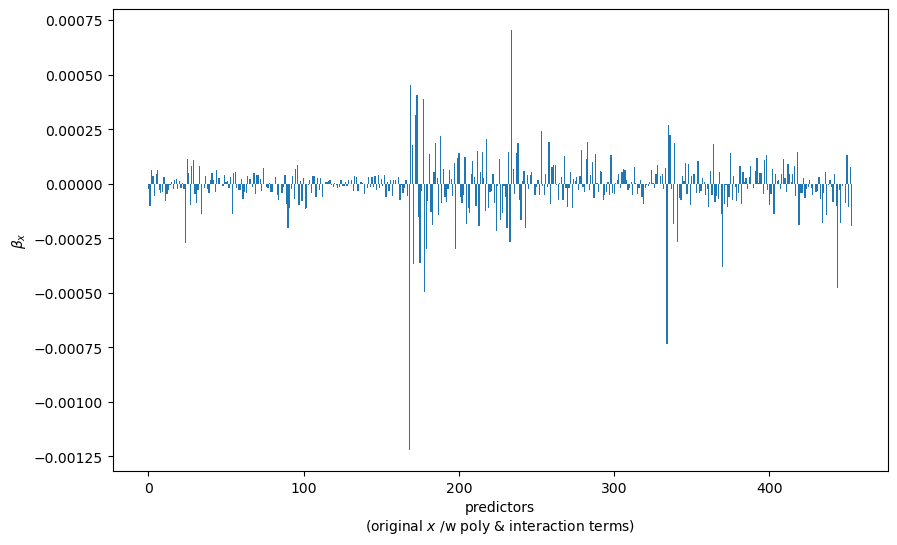

In [59]:
Bx = W@Bz
plt.figure(figsize=(10,6))
plt.bar(range(len(Bx)), Bx)
plt.ylabel(r"$\beta_x$")
plt.xlabel("predictors\n(original $x$ /w poly & interaction terms)");

You should also confirm that you get the same coefficients in terms of the predictors in $X_{\text{design}}$ when fitting a PCR model on *all* components as you would get from just fitting a linear regression on your original design matrix.

### Fit a polynomial model

You'll find making use of the `make_pipeline` function and the `Pipeline` class from SKLearn make this whole section much easier.

[sklearn.pipeline.make_pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline)

Fit and score your model.

In [60]:
poly_model = make_pipeline(StandardScaler(),
                     PolynomialFeatures(degree=3, include_bias=False),
                     LinearRegression())

In [61]:
poly_model.steps

[('standardscaler', StandardScaler()),
 ('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=False)),
 ('linearregression', LinearRegression())]

In [62]:
poly_model.fit(X_train, y_train)

poly_model.score(X_train, y_train), cross_val_score(poly_model, X_train, y_train).mean()

(0.9201946248107519, -1.2663263095889108)

In [63]:
betas = poly_model.get_params()['linearregression'].coef_

In [64]:
len(betas)

454

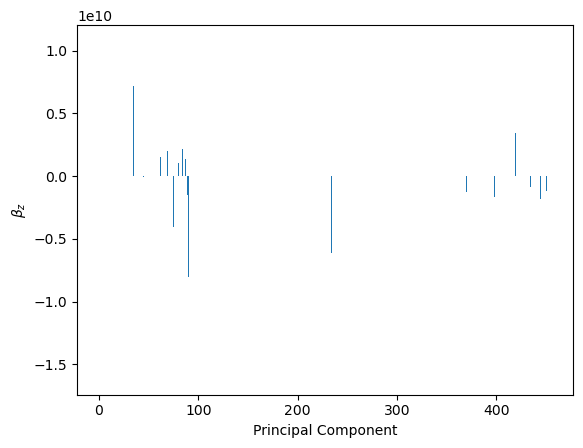

In [65]:
plt.bar(x=np.arange(1, len(betas)+1), height=betas)
plt.ylabel(r"$\beta_z$")
plt.xlabel("Principal Component");

## RidgeCV

Try again using the RidgeCV class. Do your results improve?

In [66]:
ridge = make_pipeline(StandardScaler(),
                      PolynomialFeatures(3, include_bias=False),
                      RidgeCV())
ridge.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('ridgecv', RidgeCV())])

In [67]:
ridge.score(X_train, y_train), ridge.score(X_test, y_test)

(0.9189575485817102, 0.8681120594144288)

In [68]:
cross_val_score(ridge, X_train, y_train).mean()

0.19812567602769465

In [69]:
model = ridge.get_params()['ridgecv']
# model.cv_values_.mean()

In [70]:
ridge_betas = ridge.get_params()['ridgecv'].coef_

sorted_betas = np.argsort(ridge_betas)[::-1]
ridge[1].get_feature_names_out()[sorted_betas[:6]]

array(['x3', 'x7 x11', 'x7^2', 'x0', 'x8', 'x3 x11^2'], dtype=object)

## Principle Component Regression (PCR)

Now we'll try PCR. But we'll have to decide on a choice for the number of components.

In [71]:
d = 3
pca_pipe = make_pipeline(StandardScaler(),
                         PolynomialFeatures(degree=d),
                         PCA())

In [72]:
X_pca_train = pca_pipe.fit_transform(X_train)
X_pca_test = pca_pipe.transform(X_train)

In [73]:
X_pca_train.shape

(5197, 455)

In [74]:
pca = pca_pipe.fit(X_train).get_params()['pca']
pca.n_components_

455

## PCR, choose n_components that explain 95% of variance

You can do this entirely numerically, but we should make a plot too to illustrate our approach.

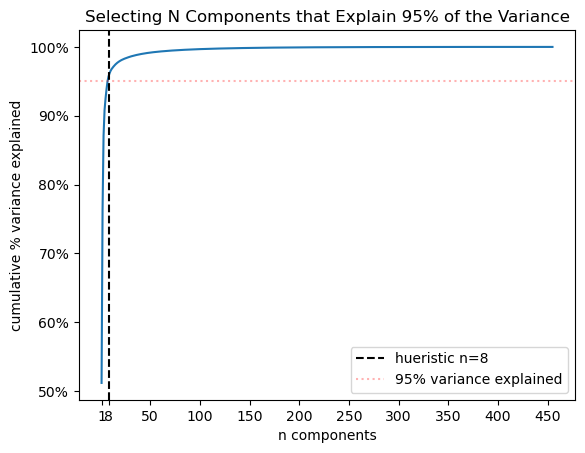

In [75]:
n_thresh = np.argmax([np.cumsum(pca.explained_variance_ratio_) >= 0.95])+1
plt.plot(range(1, pca.n_components_+1), np.cumsum(pca.explained_variance_ratio_))
# plt.xlim(1)
plt.axvline(n_thresh, ls='--', c='k', label=f'hueristic n={n_thresh}')
plt.axhline(0.95, ls=':', c='r', alpha=0.3, label=f'95% variance explained')
plt.xlabel("n components")
plt.ylabel("cumulative % variance explained")
xticks = list(range(0, pca.n_components_+1, 50)) + [n_thresh]
xticks[0] = 1
plt.xticks(xticks);
plt.legend()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.title("Selecting N Components that Explain 95% of the Variance");

Once you have your choice of `n`, fit the PCR model and score.

In [76]:
pcr_pipe = make_pipeline(StandardScaler(),
                    PolynomialFeatures(d),
                    PCA(n_components=n_thresh),
                    LinearRegression())

In [77]:
from copy import deepcopy
pcr_95var = deepcopy(pcr_pipe)
pcr_95var.fit(X_train, y_train)
pcr_95var.score(X_train, y_train), pcr_95var.score(X_test, y_test)

(0.004714715727903052, 0.004240016992764106)

## Cross-validation for choosing n_components

Try using cross validation to choose `n`!

In [79]:
# %load snippets/cv_n_components.py
max_components = 200
train_mses = np.empty(max_components)
train_stds = np.empty_like(train_mses)
val_mses = np.empty_like(train_mses)
val_stds = np.empty_like(train_mses)
lm =  LinearRegression()
for i, n in enumerate(range(1, max_components+1)):
    cv = cross_validate(lm,
                        X_pca_train[:,:n+1],
                        y_train,
                        cv=3,
                        scoring='neg_mean_squared_error',
                        return_train_score=True)
    train_mses[i] = -cv['train_score'].mean()
    train_stds[i] = cv['train_score'].std()
    val_mses[i] = -cv['test_score'].mean()
    val_stds[i] = cv['test_score'].std()

In [80]:
best_n = np.argmin(val_mses)+1
best_n

111

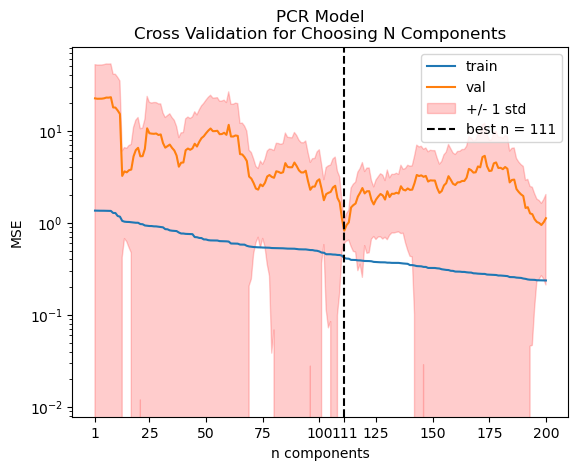

In [82]:
# %load snippets/cv_n_plot.py
plt.plot(range(1, max_components+1), train_mses, label='train')
plt.plot(range(1, max_components+1), val_mses, label='val')
plt.fill_between(range(1, max_components+1), val_mses-val_stds, val_mses+val_stds, color='r', alpha=0.2, label='+/- 1 std')
plt.yscale('log')
plt.axvline(best_n, ls='--', c='k', label=f'best n = {best_n}')
plt.legend()
xticks = list(range(0, max_components+1, 25)) + [best_n]
xticks[0] = 1
plt.xticks(xticks);
plt.xlabel('n components')
plt.ylabel('MSE')
plt.title("PCR Model\nCross Validation for Choosing N Components");

Now fit a model called `pcr_cv` using your selected $n$ and score the model.

In [83]:
pcr_cv = make_pipeline(StandardScaler(),
                    PolynomialFeatures(d),
                    PCA(best_n),
                    LinearRegression())

In [84]:
pcr_cv.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('pca', PCA(n_components=111)),
                ('linearregression', LinearRegression())])

In [85]:
pcr_cv.score(X_train, y_train), pcr_cv.score(X_test, y_test)

(0.6807332549881961, 0.6071556675317427)

## Lasso to select best PCR components

Use a pipeline with LassoCV to select the best components for the model. Select from roughly twice as many components as you found to be ideal through cross-validation.

Call your pipeline `lasso_pcr`

In [87]:
# %load snippets/lasso_pipeline.py
lasso_pcr = make_pipeline(StandardScaler(),
                    PolynomialFeatures(d, include_bias=False),
                    PCA(),
                    LassoCV(alphas=np.logspace(-4,0), eps=0.0001))

In [88]:
lasso_pcr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('pca', PCA()),
                ('lassocv',
                 LassoCV(alphas=array([1.00000000e-04, 1.20679264e-04, 1.45634848e-04, 1.75751062e-04,
       2.12095089e-04, 2.55954792e-04, 3.08884360e-04, 3.72759372e-04,
       4.49843267e-04, 5.42867544e-04, 6.55128557e-04, 7.90604321e-04,...
       9.10298178e-03, 1.09854114e-02, 1.32571137e-02, 1.59985872e-02,
       1.93069773e-02, 2.32995181e-02, 2.81176870e-02, 3.39322177e-02,
       4.09491506e-02, 4.94171336e-02, 5.96362332e-02, 7.19685673e-02,
       8.68511374e-02, 1.04811313e-01, 1.26485522e-01, 1.52641797e-01,
       1.84206997e-01, 2.22299648e-01, 2.68269580e-01, 3.23745754e-01,
       3.90693994e-01, 4.71486636e-01, 5.68986603e-01, 6.86648845e-01,
       8.28642773e-01, 1.00000000e+00]),
                         eps=0.0001))])

In [89]:
lasso_pcr.score(X_train, y_train), lasso_pcr.score(X_test, y_test)

(0.9115681265900202, 0.8654913694666023)

In [90]:
lasso_pcr[-1].alpha_

0.0011513953993264468

In [91]:
lasso_pcr_betas = lasso_pcr.get_params()['lassocv'].coef_
(np.abs(lasso_pcr_betas)>0).sum()

360

## Just LASSO

In [92]:
lassocv = make_pipeline(StandardScaler(),
                    PolynomialFeatures(degree=3, include_bias=False),
                    LassoCV())

In [93]:
lassocv.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('lassocv', LassoCV())])

In [94]:
lassocv.score(X_train, y_train), lassocv.score(X_test, y_test)

(0.8426725431749511, 0.8460992448041591)

In [95]:
lasso_betas = lassocv.get_params()['lassocv'].coef_
(np.abs(lasso_betas>0)).sum()

47

## Comparing the models

Which model performed the best on using cross validation on the training data? How about on the test?

In [96]:
models = dict(poly_model=poly_model,
              ridge=ridge,
              pcr_95var=pcr_95var,
              pcr_cv=pcr_cv,
              lasso_pcr=lasso_pcr,
              lassocv=lassocv)
print("R^2 Results\n")
print(f"\t\t\tTrain\tTest")
for name, estimator in models.items():
    print(f'{name:>15}:\t{estimator.score(X_train, y_train):.4f}\t{estimator.score(X_test, y_test):.4f}')

R^2 Results

			Train	Test
     poly_model:	0.9202	0.8654
          ridge:	0.9190	0.8681
      pcr_95var:	0.0047	0.0042
         pcr_cv:	0.6807	0.6072
      lasso_pcr:	0.9116	0.8655
        lassocv:	0.8427	0.8461


## PCA and Image Data

Let's look at the code used to generate the Fashion MNIST visualizations from lecture.

In [97]:
fashion_df = pd.read_csv('data/fashion-mnist_test.csv.zip')

X = fashion_df.drop('label', axis=1)
y = fashion_df['label']
X.shape, y.shape

fashion_labels = ['T-shirt/top',
                  'Trouser',
                  'Pullover',
                  'Dress',
                  'Coat',
                  'Sandal',
                  'Shirt',
                  'Sneaker',
                  'Bag',
                  'Ankle boot']

FileNotFoundError: [Errno 2] No such file or directory: 'data/fashion-mnist_test.csv.zip'

In [ ]:
fig, axes = plt.subplots(2,5, figsize=(10,4))
axes = axes.ravel()
for i, label_name in enumerate(fashion_labels):
    axes[i].imshow(X.iloc[np.argmax(y==i)].values.reshape(28,28), cmap='gray')
    axes[i].set(xticks=[], yticks=[])
    axes[i].set_title(label_name)
plt.tight_layout()
plt.suptitle('Fashion MNIST Dataset', y=1.05, fontsize=20);
plt.savefig('img/fashionMNIST.png')

In [ ]:
fashion_PCA = PCA(n_components=2).fit_transform(X)
def plot_reduced(X, y, labels, original_data, show_color=True, imgs=False):
    plt.figure(figsize=(15,10))
    ax = plt.gca()
    sample_idx = np.random.choice(range(len(X)), 10000, replace=False)
    X = X[sample_idx]
    y = y[sample_idx]
    for i in np.unique(y):
        color = plt.cm.tab10(i) if show_color else 'blue'
        ax.scatter(X[y==i,0], X[y==i,1],
                    color=color,
                    label=labels[i],
                    alpha=0.8)
        # include example images
        if imgs:
            example_img = original_data[y==i].values[0].reshape(int(np.sqrt(original_data.shape[1])), -1)
            scaling = 2
            example_img_big = np.repeat(np.repeat(example_img, scaling, axis=0), scaling, axis=1)
            imagebox = OffsetImage(example_img_big, cmap='gray')
            ab = AnnotationBbox(imagebox, X[y==i].mean(axis=0), frameon = False)
            ax.add_artist(ab)
    ax.legend();
    return ax

In [ ]:
ax = plot_reduced(fashion_PCA, y, fashion_labels, X, show_color=True, imgs=True)
ax.set_xlabel('1st PCA Component', fontsize=18)
ax.set_ylabel('2nd PCA Component', fontsize=18)
ax.set_title('2-D PCA Projection of Fashion MNIST Dataset', fontsize=20);

## t-SNE 

T-distributed Stochastic Neighbor Embedding t-SNE is a non-linear dimensionality reductionn method that is popular for visualization.

Unlike PCA, which can be thought of as preserving *global* structure by maintaining pair-wise distances in the projected space, t-SNE focuses on preserving *local* structure. That is, points which are 'close' in the original space should be close in the target space.

<img src='img/tsne_loss.png' width=700px>

t-SNE is just one of many nonlinear dimensionality techniques available in the sklearn `manifold` module.

In [ ]:
# load the Fashion MNIST data again
fashion_df = pd.read_csv('data/fashion-mnist_test.csv.zip')

X = fashion_df.drop('label', axis=1)
y = fashion_df['label']
X.shape, y.shape

fashion_labels = ['T-shirt/top',
                  'Trouser',
                  'Pullover',
                  'Dress',
                  'Coat',
                  'Sandal',
                  'Shirt',
                  'Sneaker',
                  'Bag',
                  'Ankle boot']

It is important to read the [TSNE documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). There are a lot of hyperparameters!

In [ ]:
fashion_tsne = TSNE(n_components=2,
                     init='random',
                     learning_rate='auto',
                     n_iter=2000,
                     n_iter_without_progress=900,
                     perplexity=50,
                     random_state=109).fit_transform(X)

In [ ]:
ax = plot_reduced(fashion_tsne, y, fashion_labels, X)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('2-D t-SNE Mapping of the Fashion MNIST Dataset', fontsize=20);
plt.savefig('img/FashionMNIST_tsne.png')

<img src='img/tsne_cons.png' width=700px>

How do your results change as we tweak the hyperparameters?